In [91]:
import os
import shutil
from re import sub
import numpy as np
import matplotlib.pyplot as plt

from keras.saving import load_model

from helper import init_resource_dicts, get_arrays, get_strings
from copy import deepcopy

# LSTM implementation # parameters ~ 10K

Files and resource dictionaries:

In [92]:
feat_file = "./Feature_files/featsNew"

data_dir = "./Transformer_Run_Results/"
stim_sets = ["EqualDefault/equalFreq", "MajDefault/majDefault", "MinDefault/minDefault"] 
test_sets = ["test", "test_Mutants", "testNewTemplates", "test_L", "test_H"]

symbol2feats, suffix2label, label2suffix = init_resource_dicts(feat_file)

In [93]:
def get_test_results(test_preds):
    """Converts integer label to string suffix"""
    return [label2suffix[label] for label in test_preds]

def get_accuracies(corr_out, pred_out):
    assert len(corr_out) == len(pred_out)
    correct = 0
    for corr_label, pred_label in zip(corr_out, pred_out):
        correct += 1 if corr_label == pred_label else 0
    return correct / len(corr_out)

def plot_learning_curve_full(accs, iterations, save_filepath):
	# plt.figure(figsize=(10, 6))
	plt.figure(figsize=(10, 6))
	plt.style.use('ggplot')
	
	# Define line styles and colors for each condition
	line_styles = {
		"Suffix A": 'dotted',
		"Suffix B": 'dashed',
		"Suffix C": 'solid'
	}

	colors = {
		"minDefault": "red",
		"equalFreq": "blue",
		"majDefault": "orange"
	}
	
	suffixes = ['Suffix A', 'Suffix B', 'Suffix C']
	default_conditions = ["minDefault", "equalFreq", "majDefault"]
	
	for suffix in suffixes:
		for condition in default_conditions:
			style = line_styles[suffix]
			color = colors[condition]
			plt.plot(iterations, accs[condition][suffix], linestyle=style, color=color)

	plt.title(f'Learning curve of logistic regression (pool-concat)', fontsize=20, pad=20) # TODO Change pool func
	plt.xlabel('Number of batches', fontsize=16)
	plt.ylabel('Average Proportion Correct', fontsize=16)
	plt.xticks(fontsize=14)
	plt.yticks(fontsize=14)
	plt.ylim(0, 1.01)
	plt.xlim(0, max(iterations))

	
	# Create custom legends for both suffixes and conditions
	suffix_legend_lines = [plt.Line2D([0], [0], color='black', linestyle=line_styles[suffix], lw=2) for suffix in suffixes]
	suffix_legend_labels = suffixes
	
	condition_legend_lines = [plt.Line2D([0], [0], color=colors[condition], lw=2) for condition in default_conditions]
	condition_legend_labels = default_conditions
	
	legend1 = plt.legend(suffix_legend_lines, suffix_legend_labels, bbox_to_anchor=(1, 0.4), loc='lower left', title="Correct Suffix", frameon=False, fontsize=12)
	legend1.set_title("Correct Suffix", prop={'size':16})
	legend1._legend_box.align = "left"
	legend2 = plt.legend(condition_legend_lines, condition_legend_labels, bbox_to_anchor=(1, 0.1), loc='lower left', title="Condition", frameon=False, fontsize=12)
	legend2.set_title("Condition", prop={'size': 16})
	legend2._legend_box.align = "left"
	
	plt.gca().add_artist(legend1)
	plt.gca().add_artist(legend2)

	plt.subplots_adjust(right=0.8)
	plt.savefig(save_filepath, format="jpg", dpi=300)


In [94]:
idx2col = {idx: col_name for idx, col_name in enumerate("Set,TestSet,Rep,Input,CorrOutput,PredOutput,Epoch".split(","))}
col2idx = {col_name: idx for idx, col_name in idx2col.items()}

conditions = ["equalFreq", "minDefault", "majDefault"]
class_types = ["Suffix A", "Suffix B", "Suffix C"] 
suffix2class = {"W AH0": "Suffix A", "L EY0": "Suffix B", "Y IY0": "Suffix C"}
num_reps = 5
num_epochs = 30

# initialize dict
epoch_acc_dict = {}
for condition in conditions:
	class_dict = {}
	for class_type in class_types:
			class_dict[class_type] = []
	epoch_acc_dict[condition] = class_dict


for epoch_num in range(30):	
	# initialize dict
	acc_dict = {}
	for condition in conditions:
		class_dict = {}
		for class_type in class_types:
				rep_dict = {}
				for rep in range(num_reps):
					rep_dict[rep] = []
				class_dict[class_type] = rep_dict
		acc_dict[condition] = class_dict
	
	epoch_filepath = f"./Transformer_Run_Results/minDef_epoch{epoch_num}_output.csv"
	with open(epoch_filepath, "r", encoding="utf-8") as log_file_handle:
		lines = [line.split(",") for line in log_file_handle.readlines() if line.split(",")[1] == "test"]

	for line in lines:
		condition = line[col2idx["Set"]]
		true_suffix = line[col2idx["CorrOutput"]]
		true_class = suffix2class[true_suffix]
		pred_suffix = line[col2idx["PredOutput"]]
		pred_class = suffix2class[pred_suffix]
		rep_number = int(line[col2idx["Rep"]])
		is_correct = 1 if true_suffix == pred_suffix else 0
		acc_dict[condition][true_class][rep_number].append(is_correct)

	# Calcuate accuracy for each rep
	for condition in conditions:
		for class_type in class_types:
			rep_acc_list = []
			for rep_num in range(num_reps):
				rep_acc = acc_dict[condition][class_type][rep_num]
				rep_acc_list.append(sum(rep_acc) / len(rep_acc))
			epoch_acc = sum(rep_acc_list) / len(rep_acc_list)

			epoch_acc_dict[condition][class_type].append(epoch_acc)
			
for condition in conditions:
	print(condition)
	for class_type in class_types:
		print(class_type)
		print(epoch_acc_dict[condition][class_type])


equalFreq
Suffix A
[0.9479166666666666, 0.9791666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Suffix B
[0.8541666666666666, 0.90625, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Suffix C
[0.15625, 0.4270833333333333, 0.6770833333333334, 0.8645833333333334, 0.875, 0.9375, 0.9895833333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
minDefault
Suffix A
[0.90625, 1.0, 1.0, 0.9791666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Suffix B
[0.8020833333333334, 0.8541666666666666, 0.9895833333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

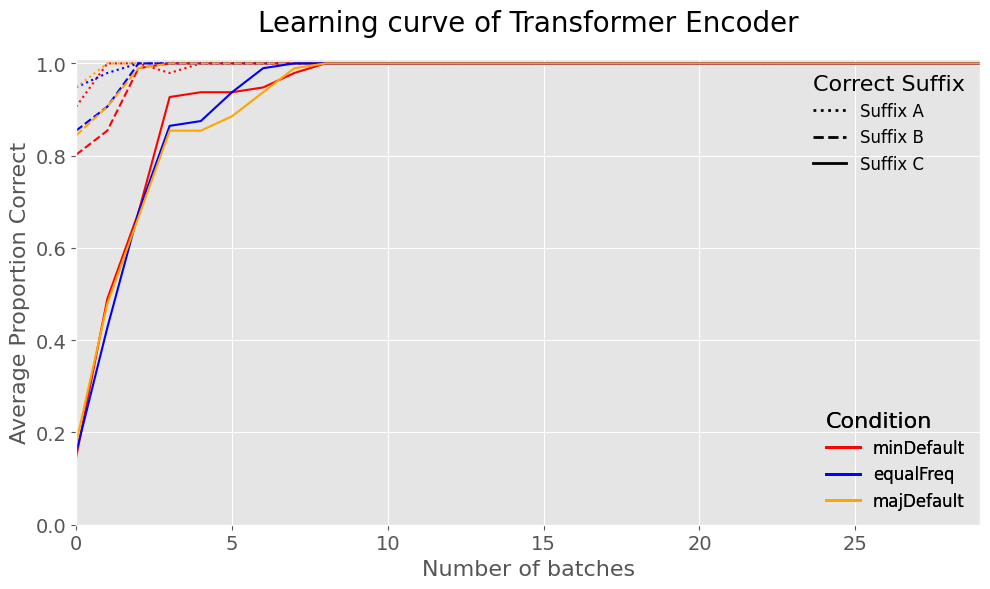

In [95]:
def plot_learning_curve_full(accs, iterations, save_filepath):
	# plt.figure(figsize=(10, 6))
	plt.figure(figsize=(10, 6))
	plt.style.use('ggplot')
	
	# Define line styles and colors for each condition
	line_styles = {
		"Suffix A": 'dotted',
		"Suffix B": 'dashed',
		"Suffix C": 'solid'
	}

	colors = {
		"minDefault": "red",
		"equalFreq": "blue",
		"majDefault": "orange"
	}
	
	suffixes = ['Suffix A', 'Suffix B', 'Suffix C']
	default_conditions = ["minDefault", "equalFreq", "majDefault"]
	
	for suffix in suffixes:
		for condition in default_conditions:
			style = line_styles[suffix]
			color = colors[condition]
			plt.plot(iterations, accs[condition][suffix], linestyle=style, color=color)

	plt.title(f'Learning curve of Transformer Encoder', fontsize=20, pad=20)
	plt.xlabel('Number of batches', fontsize=16)
	plt.ylabel('Average Proportion Correct', fontsize=16)
	plt.xticks(fontsize=14)
	plt.yticks(fontsize=14)
	plt.ylim(0, 1.01)
	plt.xlim(0, max(iterations))

	
	# Create custom legends for both suffixes and conditions
	suffix_legend_lines = [plt.Line2D([0], [0], color='black', linestyle=line_styles[suffix], lw=2) for suffix in suffixes]
	suffix_legend_labels = suffixes
	
	condition_legend_lines = [plt.Line2D([0], [0], color=colors[condition], lw=2) for condition in default_conditions]
	condition_legend_labels = default_conditions

	legend1 = plt.legend(suffix_legend_lines, suffix_legend_labels, loc='upper right', title="Correct Suffix", frameon=False, fontsize=12)
	legend1.set_title("Correct Suffix", prop={'size':16})
	legend1._legend_box.align = "left"
	
	legend2 = plt.legend(condition_legend_lines, condition_legend_labels, loc='lower right', title="Condition", frameon=False, fontsize=12)
	legend2.set_title("Condition", prop={'size': 16})
	legend2._legend_box.align = "left"
	
	
	plt.gca().add_artist(legend1)
	plt.gca().add_artist(legend2)

	plt.tight_layout()
	plt.savefig(save_filepath, format="jpg", dpi=300)

iterations = [i for i in range(30)]
plot_learning_curve_full(epoch_acc_dict, iterations, "./test.jpg")